In [1]:
import osmnx as ox
import networkx as nx
import geopandas as gdf
import matplotlib.pyplot as plt

In [ ]:
G = ox.graph_from_bbox(54.1000, 54.0669, 12.1746, 12.0728, network_type='drive')

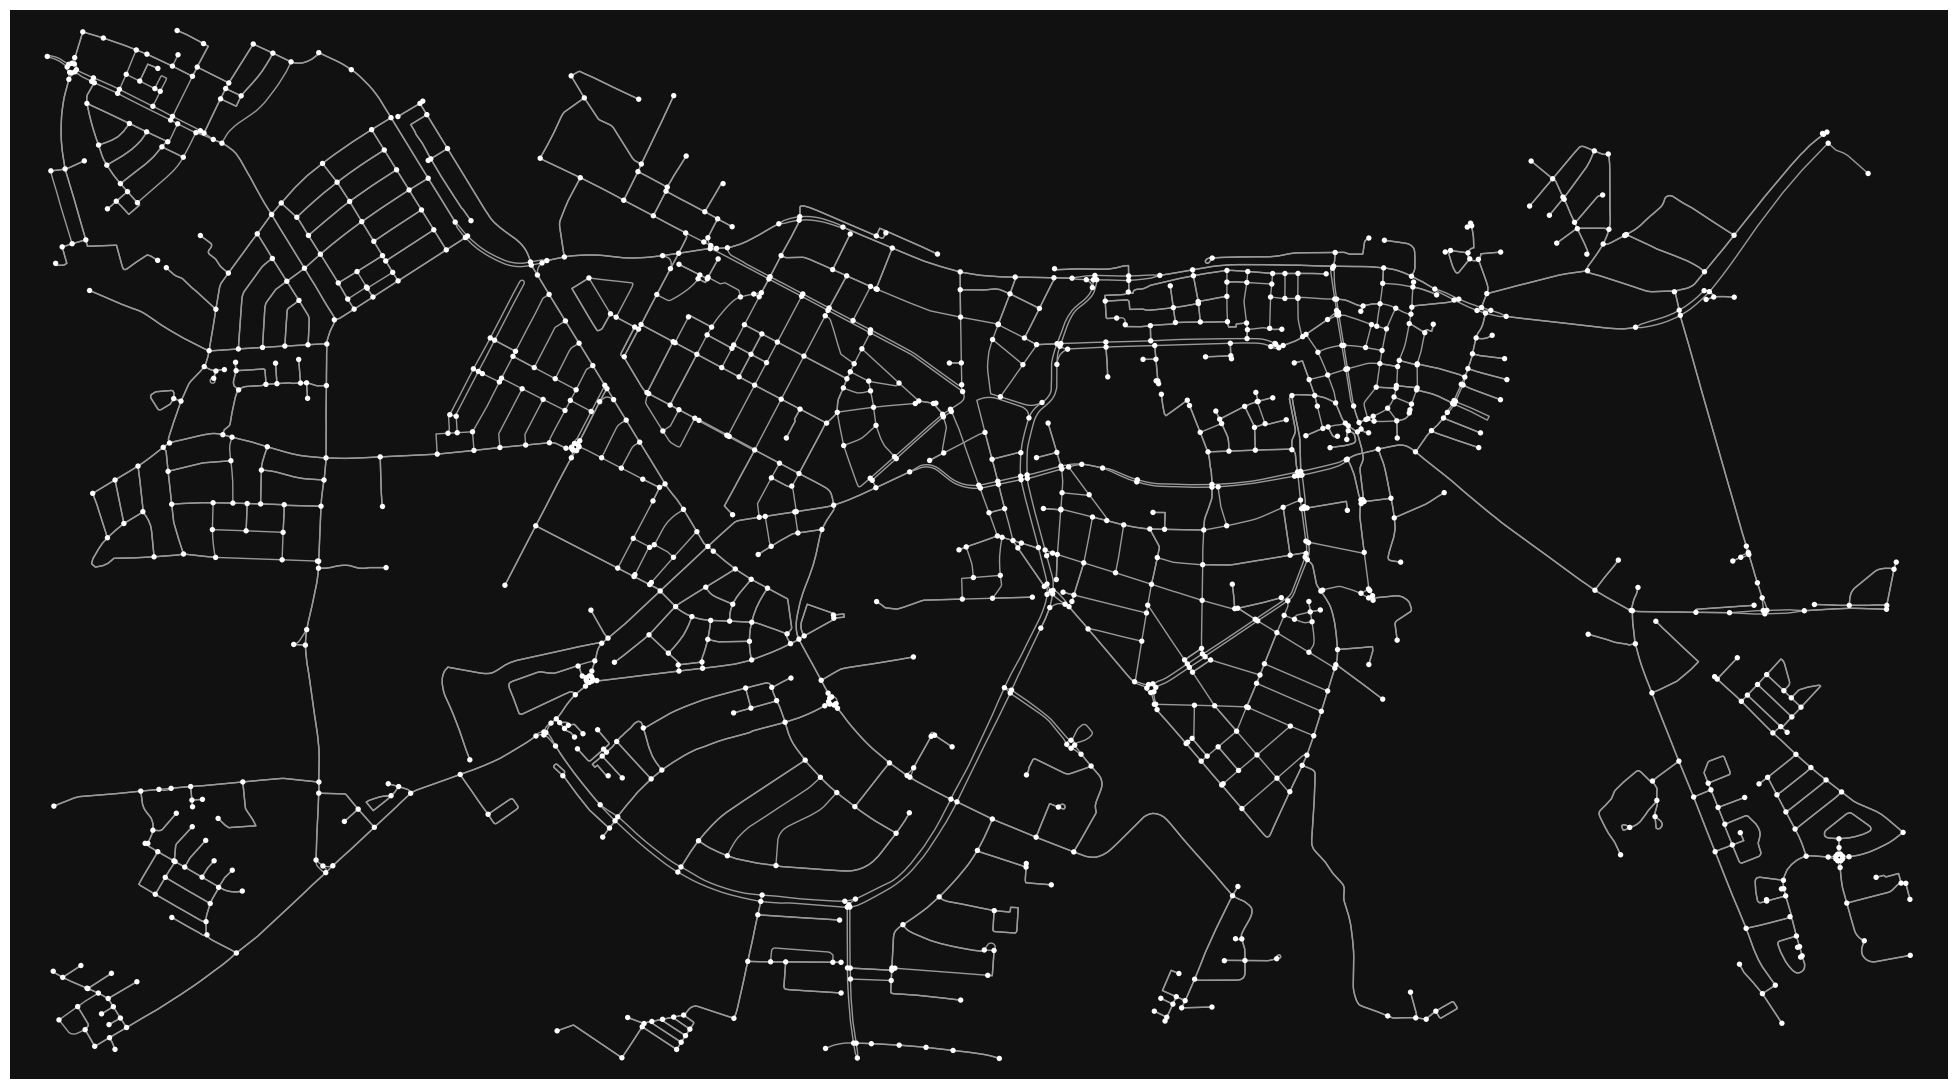

In [3]:
fig, ax = ox.plot_graph(G, figsize=(25,25))

In [64]:
nodes, edges = ox.graph_to_gdfs(G)

In [65]:
import random

In [88]:
def number_of_cars(length):
    if length<=50:
        cars = 0
    elif 50<length<=200.0:
        cars = random.randint(0,10)
    elif 200<length<=500.0:
        cars = random.randint(0,20)
    else:
        cars = random.randint(0,30)
    return cars

In [89]:
edges['cars'] = edges['length'].apply(number_of_cars)

In [90]:
def alpha(lanes,cars):
    for lanes in edges['lanes'].to_list():
        if lanes == ('1' or '[1,2]' or '[1,3]' or 'NaN'): 
            if cars <= 5: 
                value = random.uniform(0.7,0.9)
            elif 5<cars<=10:
                value = random.uniform(0.5,0.7)
            elif 10<cars<=20:
                value = random.uniform(0.4,0.5)
            else:
                value = random.uniform(0.3,0.4)
            return value
        elif lanes == ('2' or '[2,3]' or '[2,4]' or '[2,4,3]' or '[2,4,3,5]'):
            if cars <= 5: 
                value = random.uniform(0.8,0.95)
            elif 5<cars<=10:
                value = random.uniform(0.6,0.8)
            elif 10<cars<=15:
                value = random.uniform(0.5,0.6)
            else:
                value = random.uniform(0.4,0.5)
            return value
        elif lanes == ('3' or '4' or '[4,3]' or '[4,5]' or '5'):
            if cars <= 5: 
                value = random.uniform(0.9,1.0)
            elif 5<cars<=10:
                value = random.uniform(0.7,0.9)
            elif 10<cars<=15:
                value = random.uniform(0.6,0.7)
            else:
                value = random.uniform(0.5,0.6)
            return value

In [91]:
edges['alpha'] = edges.apply(lambda x: alpha(x['lanes'],x['cars']),axis = 1)

In [92]:
import pandas as pd
import numpy as np

In [93]:
edges['speed'] = np.where(edges['highway']=='residential', '30','50')

In [94]:
edges['speed'] = edges['speed'].astype(float)

In [95]:
def weight_function(length,alpha_new,speed):
    weight = (length/speed)*(1/alpha_new)*(18/5)
    return weight

In [96]:
edges['weight'] = edges.apply(lambda x: weight_function(x['length'],x['speed'],x['alpha']),axis = 1)

In [97]:
G = ox.graph_from_gdfs(nodes, edges)

In [98]:
nx.set_edge_attributes(G, name='weight', values=edges['weight'])

In [99]:
# Calculate the shortest path between two points in the road network
origin = (54.07673, 12.10655) # ITMZ
destination = (54.0982, 12.1581) # My home address
origin_node = ox.get_nearest_node(G, origin)
destination_node = ox.get_nearest_node(G, destination)
route1 = nx.shortest_path(G, origin_node, destination_node, weight='length')

In [100]:
# impute speed on all edges missing data
G = ox.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

In [101]:
route2 = nx.shortest_path(G, origin_node, destination_node, weight='travel_time')

In [102]:
route3 = nx.shortest_path(G, origin_node, destination_node, weight='weight')

In [103]:
import folium

In [104]:
map = folium.Map(location=origin, zoom_start=13)
folium.PolyLine(locations=[(G.nodes[route1[i]]['y'], G.nodes[route1[i]]['x']) for i in range(len(route1))], color='red', weight=5).add_to(map)
folium.Marker(location=origin, icon=folium.Icon(color='green')).add_to(map)
folium.Marker(location=destination, icon=folium.Icon(color='red')).add_to(map)
map

In [105]:
map1 = folium.Map(location=origin, zoom_start=13)
folium.PolyLine(locations=[(G.nodes[route2[i]]['y'], G.nodes[route2[i]]['x']) for i in range(len(route2))], color='blue', weight=5).add_to(map1)
folium.Marker(location=origin, icon=folium.Icon(color='green')).add_to(map1)
folium.Marker(location=destination, icon=folium.Icon(color='red')).add_to(map1)
map1

In [106]:
map2 = folium.Map(location=origin, zoom_start=13)
folium.PolyLine(locations=[(G.nodes[route3[i]]['y'], G.nodes[route3[i]]['x']) for i in range(len(route3))], color='green', weight=5).add_to(map2)
folium.Marker(location=origin, icon=folium.Icon(color='green')).add_to(map2)
folium.Marker(location=destination, icon=folium.Icon(color='red')).add_to(map2)
map2

In [107]:
folium.PolyLine(locations=[(G.nodes[route2[i]]['y'], G.nodes[route2[i]]['x']) for i in range(len(route2))], color='blue', weight=5).add_to(map)
folium.PolyLine(locations=[(G.nodes[route3[i]]['y'], G.nodes[route3[i]]['x']) for i in range(len(route3))], color='green', weight=5).add_to(map)
map

In [108]:
route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'length')))
route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'length')))
route3_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route3, 'length')))
route1_time = (int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, 'travel_time'))))/60
route2_time = (int(sum(ox.utils_graph.get_route_edge_attributes(G, route2, 'travel_time'))))/60
route3_time = (int(sum(ox.utils_graph.get_route_edge_attributes(G, route3, 'weight'))))/60
print('Route 1 is', route1_length, 'meters and takes', route1_time, 'minutes.')
print('Route 2 is', route2_length, 'meters and takes', route2_time, 'minutes.')
print('Route 3 is', route3_length, 'meters and takes', route3_time, 'minutes.')

Route 1 is 5115 meters and takes 9.2 minutes.
Route 2 is 5995 meters and takes 8.116666666666667 minutes.
Route 3 is 5290 meters and takes 9.5 minutes.


In [109]:
edge_colors = []
for alpha in edges['alpha']:
    if alpha > 0.9:
        edge_colors.append('green')
    elif alpha > 0.7:
        edge_colors.append('yellow')
    elif alpha > 0.5:
        edge_colors.append('orange')
    else:
        edge_colors.append('red')

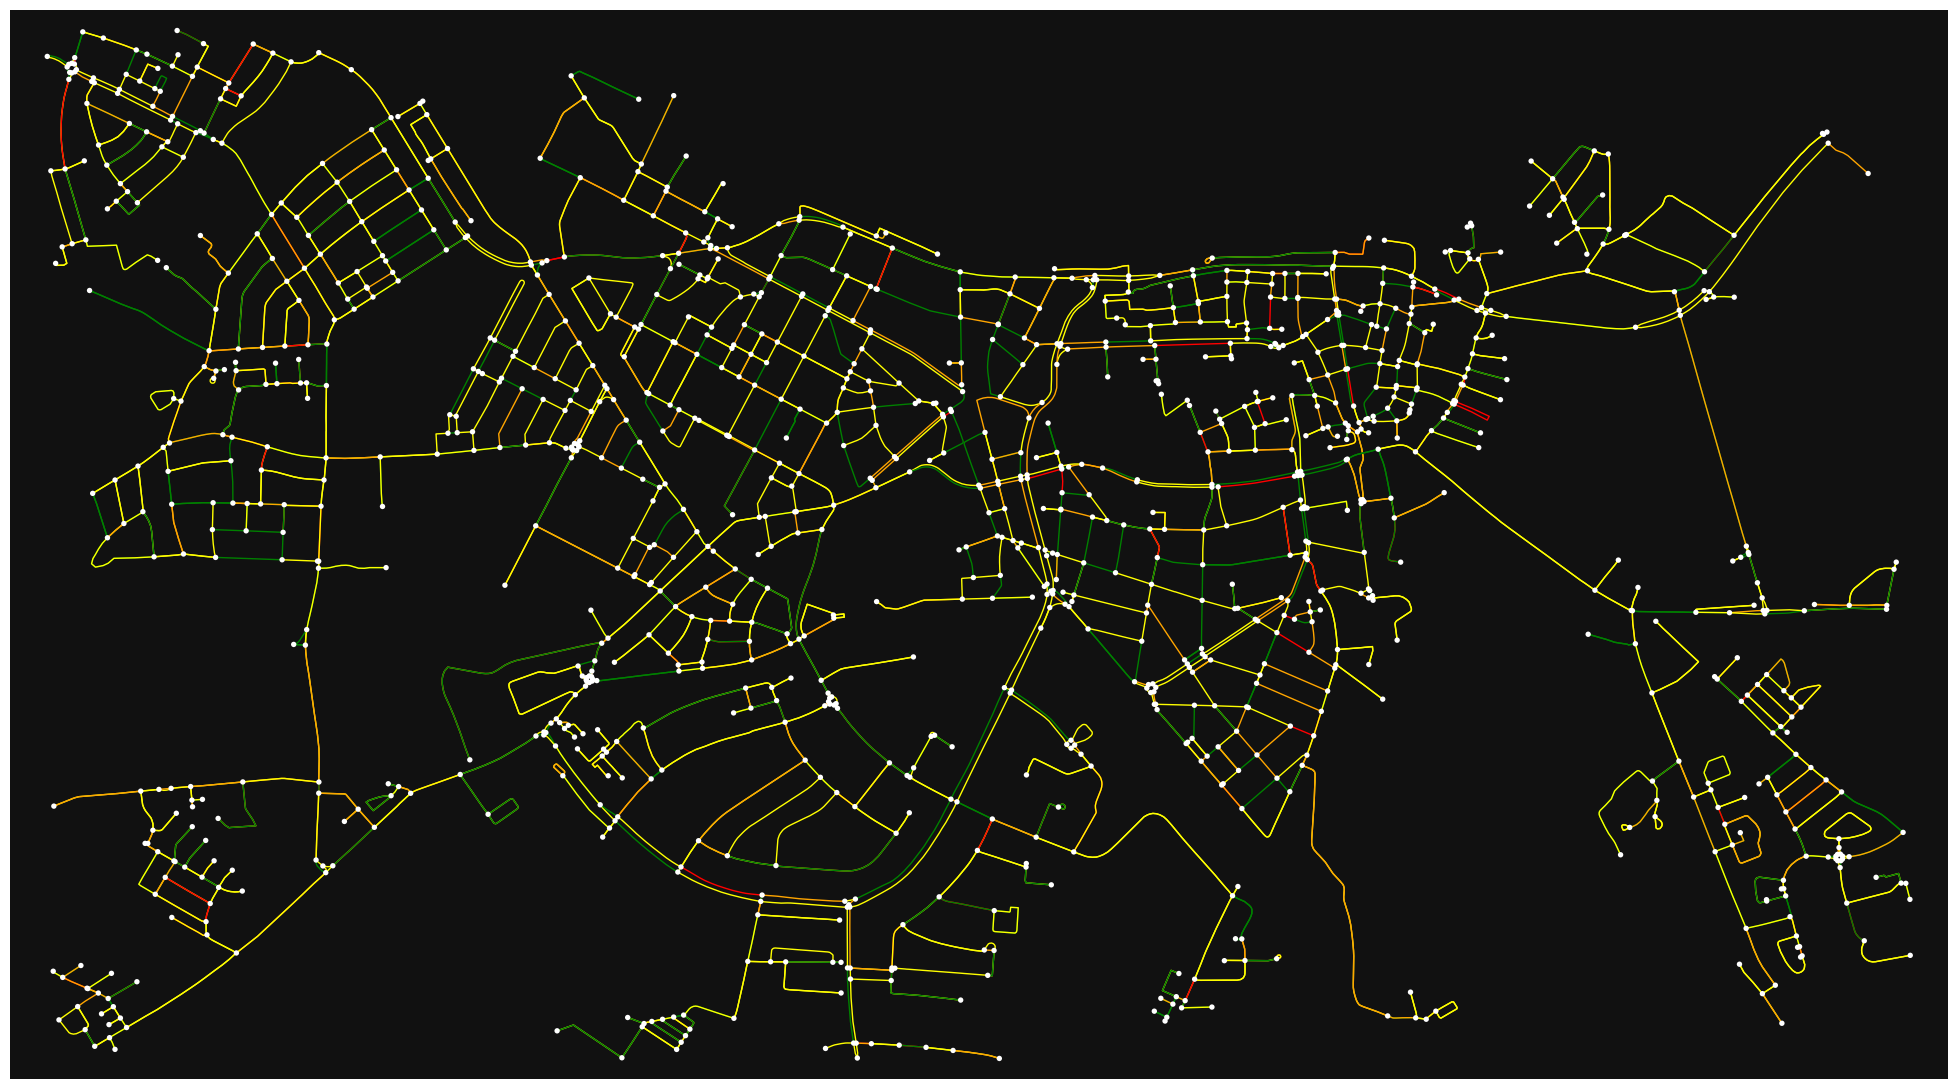

In [110]:
fig, ax = ox.plot_graph(G, edge_color=edge_colors, figsize=(25,25))